In [1]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt  
import geopandas as gpd  
import folium  
from shapely import wkb  
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN, KMeans 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import train_test_split  

# Load Dataset

In [2]:

df = pd.read_csv("other_industries_original_unaltered.csv", dtype=str)  # Load all columns as strings initially


# Data Inspection

In [3]:

print("Data Overview:")
print(df.head())
print(df.info())

Data Overview:
       id sr_no      state state_lgd_code    district district_lgd_code  \
0       -     4  Tamilnadu             33  Tiruvallur               589   
1       -   224  Tamilnadu             33     Chennai               568   
2    01#1   853  Karnataka             29      KODAGU               541   
3   01#10   857  Karnataka             29      KODAGU               541   
4  01#100   880  Karnataka             29  RAMANAGARA               631   

         city                          name_of_industry  \
0  Tiruvallur         Qute Extrusions Private \nLimited   
1     Chennai  CENTRAL INVESTIGATION & SECURITY SERVICE   
2    Madikeri                        Astra Processors,    
3    Madikeri                 Amritha Coffee  Pvt Ltd,    
4   Ramnagara                           Mathas Coffee,    

                                    complete_address    phone_no  ...  \
0  K-33-N & S, Phase II, Sipcot Industrial \nComp...           -  ...   
1  L56, Old No:49/3,11th Avenue,A

# Data Cleaning

- Handling Missing Values

In [4]:
df.replace(to_replace=['NULL', 'null', '', ' '], value=np.nan, inplace=True)
missing_data = df.isnull().sum() / len(df) * 100
print("Missing Values Percentage:")
print(missing_data.sort_values(ascending=False))

C:\Users\user\AppData\Local\Temp\ipykernel_11840\359559028.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace=['NULL', 'null', '', ' '], value=np.nan, inplace=True)


Missing Values Percentage:
f23                     100.000000
id_1                     99.357786
email_id                 79.325229
phone_no                 71.284996
city                     70.248382
bis_id                   42.834004
lab_count                32.566671
voluntary_mandatory      32.267025
licenses_count           32.214385
is_number_year           30.881364
lgd_district_id          30.243199
is_title                 29.534577
lgd_state_id             28.047684
year                     27.935924
is_number                24.604184
longitude                23.525458
geom                     23.525458
latitude                 23.525458
products_manufacture     16.952680
sr_no                    11.448100
district_lgd_code        11.374404
state_lgd_code            6.980944
scale                     6.837600
complete_address          1.767912
district                  0.892459
state                     0.669750
branch                    0.668940
name_of_industry          0.


## Trim whitespace from text columns

In [5]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()


## Convert numeric columns

In [6]:

df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['licenses_count'] = pd.to_numeric(df['licenses_count'], errors='coerce')
df['lab_count'] = pd.to_numeric(df['lab_count'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Data Visualization
- Missing Values Heatmap

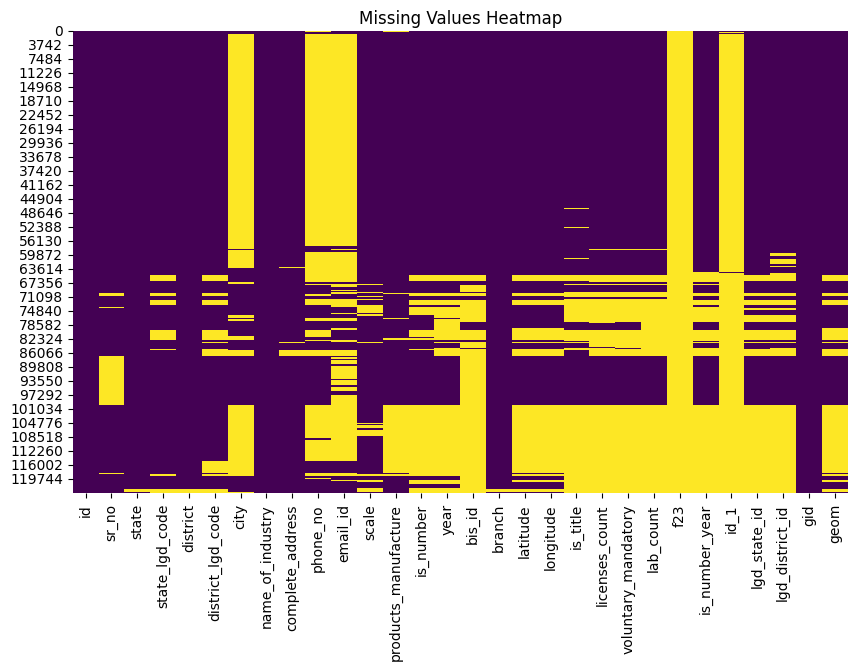

In [7]:

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Geospatial Visualization

- Convert WKB Geometry to Shapely Geometries

In [8]:

def parse_geom(geom_str):
    try:
        return wkb.loads(geom_str, hex=True)
    except Exception:
        return None
    


df['geometry'] = df['geom'].apply(lambda x: parse_geom(x) if pd.notnull(x) else None)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

,id,sr_no,state,state_lgd_code,district,district_lgd_code,city,name_of_industry,complete_address,phone_no,...,voluntary_mandatory,lab_count,f23,is_number_year,id_1,lgd_state_id,lgd_district_id,gid,geom,geometry
0,-,4,Tamilnadu,33,Tiruvallur,589,Tiruvallur,Qute Extrusions Private \nLimited,"K-33-N & S, Phase II, Sipcot Industrial \nComp...",-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111082,0101000020E6100000C662E5E14E075440A5434C2E6BDB...,POINT (80.11419 13.42855)
1,-,224,Tamilnadu,33,Chennai,568,Chennai,CENTRAL INVESTIGATION & SECURITY SERVICE,"L56, Old No:49/3,11th Avenue,Ashok Nagar,Chenn...",9840357078,...,-,NaN,NaN,-,NaN,-,-,74841,0101000020E6100000DBD2B4D5760D54407845F0BF9510...,POINT (80.21038 13.03239)
2,01#1,853,Karnataka,29,KODAGU,541,Madikeri,"Astra Processors,","Plot no. 25, KIADB Industrial Area, Kudlur, ...",NaN,...,Voluntary,8.0,NaN,IS 2791 : 1992,439,29,541,3,0101000020E6100000EBE005B66FFD524008A062E64CF6...,POINT (75.95994 12.48106)
3,01#10,857,Karnataka,29,KODAGU,541,Madikeri,"Amritha Coffee Pvt Ltd,","Plot no. 30 KIADB Industrial Area ,Kudlur, Kus...",NaN,...,Voluntary,8.0,NaN,IS 2791 : 1992,443,29,541,12,0101000020E6100000EBE005B66FFD524008A062E64CF6...,POINT (75.95994 12.48106)
4,01#100,880,Karnataka,29,RAMANAGARA,631,Ramnagara,"Mathas Coffee,","No. 109, SLV Valley Industries, Rachana Math V...",NaN,...,Voluntary,8.0,NaN,IS 2791 : 1992,498,29,631,20048,0101000020E610000081C79EDAEC5A53400AA1FFF53C11...,POINT (77.42071 12.53367)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123474,23./12/2024/KKBO/96,96,West Bengal,19,Howrah,NaN,NaN,Prestige Ice Creams,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142862,NaN,None
123475,23./12/2024/KKBO/97,97,West Bengal,19,Howrah,NaN,NaN,Prism Johnson,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142863,NaN,None
123476,23./12/2024/KKBO/98,98,West Bengal,19,Howrah,NaN,NaN,Rahee Group,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142864,NaN,None
123477,23./12/2024/KKBO/99,99,West Bengal,19,Howrah,NaN,NaN,Ramkrishna Forgings,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142865,NaN,None


In [9]:
## Create Map
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)
for _, row in gdf.iterrows():
    if not pd.isnull(row.latitude) and not pd.isnull(row.longitude):
        folium.Marker([row.latitude, row.longitude], popup=row['branch']).add_to(m)
m.save("industry_map.html")

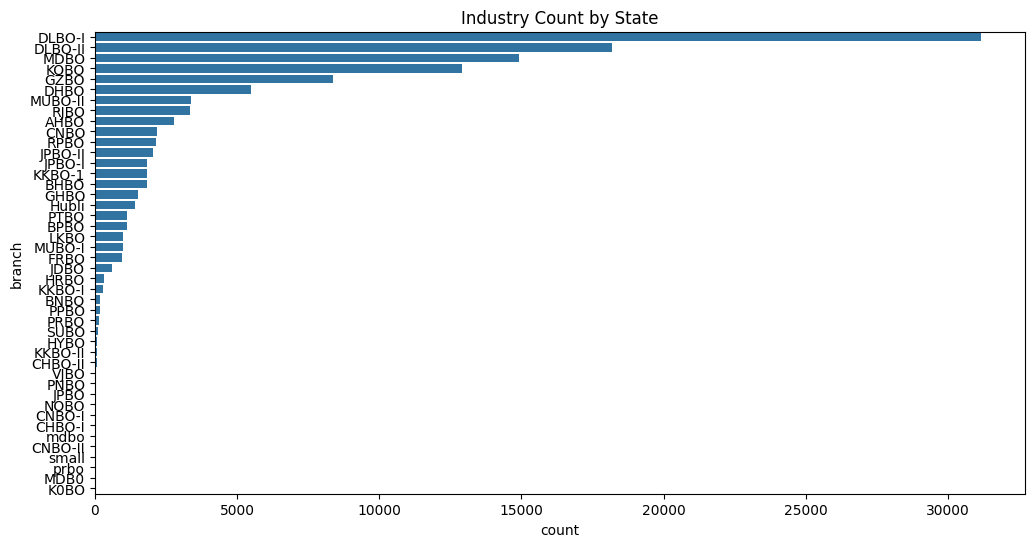

In [10]:
# Industry Trends Analysis
plt.figure(figsize=(12, 6))
sns.countplot(y=df['branch'], order=df['branch'].value_counts().index)
plt.title("Industry Count by State")
plt.show()

# Anomaly Detection (DBSCAN)

In [11]:
coords = df[['latitude', 'longitude']].dropna().values
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(coords)
df['anomaly'] = dbscan.labels_
print("Anomalies Found:")
print(df[df['anomaly'] == -1])

MemoryError: 

# Clustering (K-Means)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
df = df.dropna(subset=['latitude', 'longitude'])
df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis')
plt.title("Industry Clusters")
plt.show()

# Predict Missing Data (Random Forest)

In [ ]:
df.dropna(subset=['scale'], inplace=True)
X = df[['latitude', 'longitude', 'branch']]
y = df['scale']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
print("Model Accuracy:", model.score(X_test, y_test))

# Industrial Hotspot Prediction (Decision Tree)


In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
prediction = model.predict([[12.9716, 77.5946, 'Karnataka']])
print("Predicted Industry Scale for Bangalore:", prediction)

# Data Completeness Dashboard

In [ ]:
plt.figure(figsize=(10, 6))
missing_data.sort_values().plot(kind='barh')
plt.title("Missing Data Percentage per Column")
plt.show()